# <center> Single Channel Queuing Example
## <center> Systems Engineering and Analysis
## <center> <img src="https://www.engr.colostate.edu/~jdaily/Systems-EN-CSU-1-C357.svg" width="400" /> 
### <center> Prepared by: Dr. Jeremy Daily

## The M/M/1 Queue System

The M/M/1 Queue is named using the Kendall Notation, which denotes the arrival process, the service time distribution, and the number of service units. 

The M stands for Markovian (or Memoryless). It uses an exponential distribution to describe the time spacing of the arrival or servicing events. 


https://en.wikipedia.org/wiki/Kendall%27s_notation

The SYSE530 course text describes this system in Section 10.3 as Single-Channel Queuing Model.

https://en.wikipedia.org/wiki/M/M/1_queue

Some additional reading for fun:

https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon, norm

### Number of Arrivals per Time Period
In the following block, we'll simulate a Poisson distribution to describe the number of units arriving to a queuing system. We'll be using the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

For additional context, see https://en.wikipedia.org/wiki/Poisson_point_process.

From the example on Page 299 of B&F, suppose a queue experiences Poisson arrives with a mean rate of 1/10 units per time period. This means 
$$ \lambda = 10 $$
in the book's notation. 

average number of arrivals per time = 10


Text(0.5, 0, 'Number of arrivals')

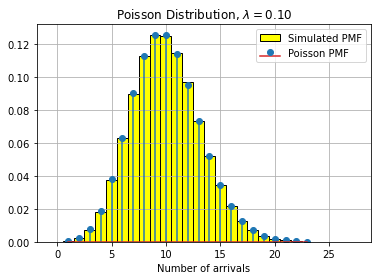

In [3]:
# Simulate many samples
N=100000

# Define the mean arrival rate
arrival_rate_mean = 10

# Specify  the number of arrivals per period
# use lam instead of lambda because lambda is a protected word in Python
lam = 1/arrival_rate_mean

print("average number of arrivals per time = {}".format(arrival_rate_mean))

#Generate random values from the poisson distribution
arrival_counts = poisson.rvs(arrival_rate_mean,size=N)

#Draw a normalized histogram and compare it to the theoretical distribution
#place the bins in the center of the discrete values for the samples
bins = np.arange(0, max(arrival_counts) + 1.5) - 0.5

#Show the emperical distribution of the generated random values
plt.hist(arrival_counts,
         bins=bins,density=True,color="yellow",
         ec="black",label="Simulated PMF");

#Generate a range for the theoretical mass function
x = np.arange(poisson.ppf(0.0001, arrival_rate_mean),
              poisson.ppf(0.9999, arrival_rate_mean))
#Plot the theoretical PMF
plt.stem(x, poisson.pmf(x, arrival_rate_mean),   label='Poisson PMF')
plt.legend()
plt.grid()
plt.title("Poisson Distribution, $\lambda = {:0.2f}$".format(lam));
plt.xlabel("Number of arrivals")

In [3]:
#compare simulation mean 
arrival_counts.mean()

9.99657

### Time between each arrival
The space between each arrival in Poisson process is distributed as an exponential distribution.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html

The scale factor for the distribution is $1/\lambda $ which equals the arrival rate.

We'll simulate the arrival spacing for the queue.

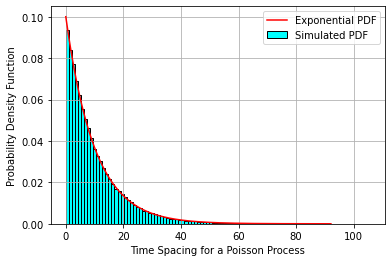

In [4]:
#Show the emperical distribution of the generated random values
#place the bins in the center of the discrete values for the samples
arrival_intervals = expon.rvs(scale=arrival_rate_mean,size=N)
plt.hist(arrival_intervals,bins=100,density=True,color="cyan",ec="black",label="Simulated PDF");
#Generate a range for the theoretical mass function
x = np.arange(expon.ppf(0.0001, scale=arrival_rate_mean),
              expon.ppf(0.9999, scale=arrival_rate_mean),0.01)
#Plot the theoretical PMF
plt.plot(x, expon.pdf(x, scale=arrival_rate_mean),  'r-', label='Exponential PDF')
plt.legend()
plt.grid()
plt.xlabel("Time Spacing for a Poisson Process")
plt.ylabel("Probability Density Function");

In [5]:
# Determine theoretical moments for the distribution
mean, var, skew, kurt = expon.stats(scale=arrival_rate_mean,moments='mvsk')
print(mean, var, skew, kurt)

10.0 100.0 2.0 6.0


In [6]:
#Compare to the simulated distribution
arrival_intervals.mean()

10.04381909496306

In [7]:
#Theoretical mean
1/lam

10.0

In [8]:
#Compare to the simulated distribution variance
arrival_intervals.var()

100.22212207379359

### Simulate the distribution describing time for servicing
This is also an exponential distribution

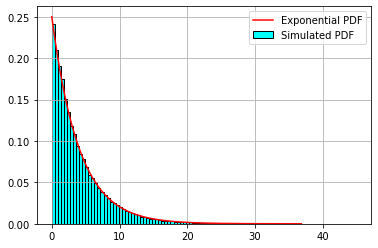

In [10]:
#Generate random values from the exponential distribution
service_time_mean = 4
# Determine the service rate
mu = 1/service_time_mean #Book notation for service completions per period

service_times = expon.rvs(scale=service_time_mean,size=N)

#place the bins in the center of the discrete values for the samples
bins = 100

#Show the emperical distribution of the generated random values
plt.hist(service_times,bins=bins,density=True,color="cyan",
         ec="black",label="Simulated PDF");

#Generate a range for the theoretical mass function
x = np.arange(expon.ppf(0.0001, scale=service_time_mean),
              expon.ppf(0.9999, scale=service_time_mean),0.01)
#Plot the theoretical PMF
plt.plot(x, expon.pdf(x, scale=service_time_mean),
         'r-', label='Exponential PDF')
plt.legend()
plt.grid()

In [11]:
mean, var, skew, kurt = expon.stats(scale=service_time_mean,moments='mvsk')
print(mean, var, skew, kurt)

4.0 16.0 2.0 6.0


In [12]:
#theroretical expected value (mean)
1/mu

4.0

In [13]:
#Compare to the simulated distribution
np.array(service_times).mean()

3.9728726945722745

In [14]:
#Theoretical variance
1/mu**2 

16.0

In [15]:
#Compare to the simulated distribution
np.array(service_times).var()

15.908585783213965

### Will there be convergence?
This is the first check for a queue. Will the queue be able to handle the in-flux. The processing has to be faster than the arrivals or else the queue will back up. See the note after Eqn. 10.9 in B&F.

In [16]:
# check the ratio to see if it is less than 1 to get convergence
print(lam/mu)
if lam/mu < 1:
    print("Convergence Criteria Achieved.")
else:
    print("Queue will not converge. The arrivals are faster than the servicing")

0.4
Convergence Criteria Achieved.


## Simulate a Queuing System
We'll setup a routine that loops through time and processes "customers." The customer arrival time is separated by a random time that is exponentially distributed. The processing time will be determined by a random sample from another exponential distribution. With both of these distributions as exponential, we can determine theoretical properties for the M/M/1 system. 

The customer has it's own needs, so we'll define it's servicing time when the customer is created (i.e. arrives to the queue).

We'll use an object-oriented approach and create a class the defines the customer and some of it's properties and functions. 

In [17]:
#Create an object that can keep track of itself through the system
# Pass in an identifier and the global arrival time. 

class Customer():
    def __init__(self,id,arrival):
        self.id = id
        self.wait_time = 0
        self.arrival_time = arrival
        #Use a sample from a random variable for the service time
        self.service_time = expon.rvs(scale=service_time_mean) 
        #self.service_time = abs(norm.rvs(loc=4,scale=1) )
        # This is a minimum. It will be updated upon ejection from the queue system
        self.finished_time = self.arrival_time + self.service_time + self.wait_time
        
    def get_queue_time(self):
        self.queue_time = self.finished_time - self.arrival_time
        return self.queue_time

### Simulate the Queue
This is a Monte Carlo simulation of the Single Channel Queuing Model as described in Section 10.3 of B&F.

In [24]:
# This is for printout of the queue simulation
# Set this to zero to suppress output
debug_periods = 0

# Initialize some lists to keep track of the queue performance.
finished_customers = []
customers_in_line = []
customers_in_system = []
customer_wait_time = []
customer_system_time = []


# Specify the number of time periods to run
# Iterate to find convergence.
#for time_periods in [100000,200000,400000]:


# Make an ordered list the waiting line of the queue system
# We can add elements uing the append method
# We can remove elements using the pop method
waiting_line = []


system_size=0
arrivals = 0
arrival_time = 0
# This creates an instance of the customer
# We pass the id of the customer into the constructor
# The first time is zero (second argument)
# If the service_cust is defined, then it is in service. 
service_cust = Customer(arrivals,arrival_time)
# Always add one when the customer is created
system_size += 1
# Always update the arrival time of the next customer with a sample from the 
# exponential distribution
arrival_time += expon.rvs(scale=arrival_rate_mean)
times = []
time_periods = 1000000
delta_t=0.01
total_time = time_periods*delta_t
print("total time:", total_time)
t=0
while t < total_time:
    # Calculate the current time as t
    t += delta_t
    times.append(t)
    # Keep track of how many customers are in the system
    customers_in_system.append(system_size)
    # Keep track of customers in line
    customers_in_line.append(len(waiting_line))

    # Check for new arrivals
    if t >= arrival_time:
        arrivals += 1
        # Create a customer to simulate an arrival. 
        # The customer class generates its own servicing time.
        cust = Customer(arrivals,arrival_time)
        # Always increase the number of customers in the system
        system_size += 1

        # update the arrival time with the next arrival
        arrival_time += expon.rvs(scale=arrival_rate_mean)

        if t < debug_periods:
            print("t = {}, waiting_line length = {}".format(t,len(waiting_line)))
            print("Created Customer {} at time {} with service time of {}".format(cust.id, cust.arrival_time, cust.service_time))

        # Put the newly created customer in the wait line
        waiting_line.append(cust)

    # Check to see if a customer is finished
    #Be sure there is a customer in service
    if service_cust is not None:
        # Since the customer is in service, we should see if it's done.
        if t >= service_cust.finished_time:
            if t < debug_periods:
                print("Customer {} finished at time {}".format(service_cust.id, t))
            # Keep track of customers coming through the queue
            finished_customers.append(service_cust)
            customer_system_time.append(service_cust.get_queue_time())
            # Remove the customer from the system.
            system_size -= 1
            # Let the program know there is no customer being serviced.
            service_cust = None
    else:
        #There's no customer in service, so only the ones in the line are in the system
        try:
            # Get a customer from the line
            service_cust = waiting_line.pop(0)
        except IndexError:
            # There wasn't anyone in line, so move to the next time.
            continue
        # determine how long they were in the wait line    
        service_cust.wait_time = t - service_cust.arrival_time
        # Keep track of the wait time.
        customer_wait_time.append(service_cust.wait_time)
        # Determine when the finish should be
        service_cust.finished_time = t + service_cust.service_time

        if t < debug_periods:
            print("Retrieved Customer {} from the line at time {:0.3f} after waiting {:0.3f}.".format(service_cust.id, t, service_cust.wait_time))
            print("Anticipated finish for {} is {:0.3F}".format(service_cust.id,service_cust.finished_time))
N=time_periods//2
print("np.mean(customers_in_system)",np.mean(customers_in_system[N:]))

total time: 10000.0
np.mean(customers_in_system) 0.598296


Note: Convergence is slow for this system. Orders of magnitude more samples are required for convergence

### Average number of customers waiting in line

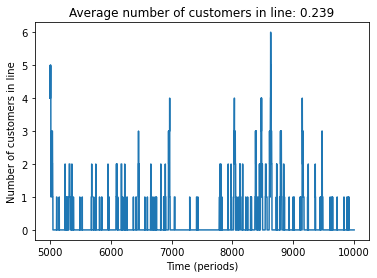

In [25]:
average_number_in_line = np.mean(customers_in_line[N:])
#times = np.arange(N)*delta_t
plt.plot(times[N:],customers_in_line[N:])
plt.xlabel("Time (periods)")
plt.ylabel("Number of customers in line")
plt.title("Average number of customers in line: {:0.3f}".format(average_number_in_line));

In [26]:
# Theoretical average length of line
# See Equation 10.11
L_q = lam**2/(mu*(mu-lam))
L_q

0.2666666666666667

### Average waiting time for customers in line

In [27]:
# Average simulated time in line
np.mean(customer_wait_time)

3.6346417309900727

In [28]:
# Theoretical mean time an arrival waits for service
# Equation 10.18
W_q = lam/(mu*(mu-lam))
W_q

2.666666666666667

### Average time spent in the queuing system

In [29]:
# Average simulated time in the whole system
np.mean(customer_system_time)

7.743870602542026

In [30]:
# Theoretical average customer time through the queue.
# Equation 10.19
t_m = 1/(mu-lam)
t_m

6.666666666666667

### Average number of customers in the system
This includes both customers in line and customers being serviced.

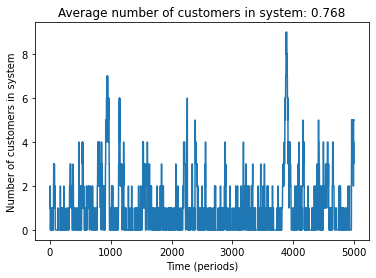

In [31]:
# Incorporate less samples to see the operation of the queue
# Also include some measures
average_number_in_system = np.mean(customers_in_system)
#Reduce the samples for faster plotting
plt.plot(times[:N],customers_in_system[:N])
plt.xlabel("Time (periods)")
plt.ylabel("Number of customers in system")
plt.title("Average number of customers in system: {:0.3f}".format(average_number_in_system));

In [32]:
# Mean theoretical length or elements in the system
# Equation 10.10
L = lam/(mu-lam)
L

0.6666666666666667

In [33]:
# Probability of size of the line at any time (steady state)
#Eq 10.9
def Pn(n,l=lam,mu=mu):
    assert type(n)==int
    return (1-l/mu)*(l/mu)**n

pmf=[]
x = []
expected_val = 0
for n in range(15):
    x.append(n)
    pmf.append(Pn(n))
    print(n,Pn(n))
    
    expected_val += n*Pn(n)

0 0.6
1 0.24
2 0.09600000000000002
3 0.03840000000000001
4 0.015360000000000002
5 0.006144000000000001
6 0.0024576000000000008
7 0.0009830400000000003
8 0.0003932160000000002
9 0.00015728640000000008
10 6.291456000000003e-05
11 2.5165824000000015e-05
12 1.0066329600000006e-05
13 4.026531840000002e-06
14 1.6106127360000012e-06


In [34]:
#Expected Value Verification
print(expected_val,"=?=",L)

0.6666498447114242 =?= 0.6666666666666667


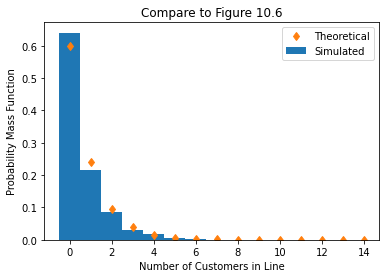

In [35]:
# This cell takes a while with large samples
#place the bins in the center of the discrete values for the samples
bins = np.arange(0, max(customers_in_system[N:]) + 1.5) - 0.5
vals,bins,_ = plt.hist(customers_in_system[N:], bins=bins, density=True,label="Simulated")
plt.plot(x,pmf,'d',label="Theoretical")
plt.xlabel("Number of Customers in Line")
plt.ylabel("Probability Mass Function")
plt.title("Compare to Figure 10.6")
plt.legend();

In [36]:
# Compute the expected value of the simulated distribution 
expected_sum = 0
for v,b in zip(vals,bins):
    expected_sum += v*(b+.5)
#this should closely match the average_number_in_system
expected_sum

0.5982959999999999

In [37]:
# This is the same as before
average_number_in_system

0.768224

### Minimum Cost Service Rate
The expected cost of the queuing system is the sum of the expected waiting period and the expected facility cost per period.
$$ TC_m = WC_m + FC_m$$
where
$$ WC_m = C_w\times n_m = \frac{C_w\lambda}{\mu-\lambda}$$
and 
$$ FC_m = C_f\times\mu $$
The costs are $C_w$ that represents the cost of waiting during the period and $C_f$ is the cost of servicing.

To optimize, take the derivative of Total Cost with respect to $\mu$ and set to zero. Solving gives

$$ \mu = \lambda +\sqrt{\frac{\lambda C_w}{C_f}}$$

In [38]:
from math import inf
#Example in Section 10.3.5
lamb = 1/8
Cw = 0.10
Cf = 0.165

#Construct Table 10.1
print("mu   WC_m   FC_m   TC_m")
for muu in [0.125, 0.150, 0.200, 0.250, 0.300, 0.400, 0.500, 0.600, 0.800, 1.000]:
    FC_m = Cf*mu
    try:
        WC_m = Cw*lam/(muu-lamb)
        TC_m = WC_m + FC_m
    except ZeroDivisionError:
        WC_m = inf
        TC_m = inf
    print("{:0.2f}  {:0.2f}  {:0.2f}  {:0.3f}".format(muu, WC_m, FC_m, TC_m))

mu   WC_m   FC_m   TC_m
0.12  inf  0.04  inf
0.15  0.40  0.04  0.441
0.20  0.13  0.04  0.175
0.25  0.08  0.04  0.121
0.30  0.06  0.04  0.098
0.40  0.04  0.04  0.078
0.50  0.03  0.04  0.068
0.60  0.02  0.04  0.062
0.80  0.01  0.04  0.056
1.00  0.01  0.04  0.053


In [39]:
#Optimal Cost Using Equation 10.24
from math import sqrt
muu = lamb + sqrt(lamb*Cw/Cf)
muu

0.40024094128159016

This is the service rate that minimizes the cost of the queuing system.